# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

* About Data

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [1]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

## Helper Functioins

In [2]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [3]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [4]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [6]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1404 has been set.
GPU is enabled in this notebook.


## Download EMNIST dataset

* For this assignment, we will use the EMNIST letters dataset, which consists of binarized images of handwritten characters.

* We only keep the images that correspond to **X** and **O**. Then, we will train a CNN to classify an image as either an **X** or an **O**.

In [7]:
# webpage: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)




Extracting the files...



## Dataset/DataLoader Functions

In [8]:
def get_Xvs0_dataset(normalize=False, download=False):
  """
  Load Dataset

  Args:
    normalize: boolean
      If true, normalise dataloader
    download: boolean
      If true, download dataset

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='.',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='.',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # Only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test


def get_data_loaders(train_dataset, test_dataset,
                     batch_size=32, seed=0):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    batch_size: int
      Batch Size
    seed: int
      Set seed for reproducibility

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader

In [9]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

Here, you can see a couple of samples from the dataset.

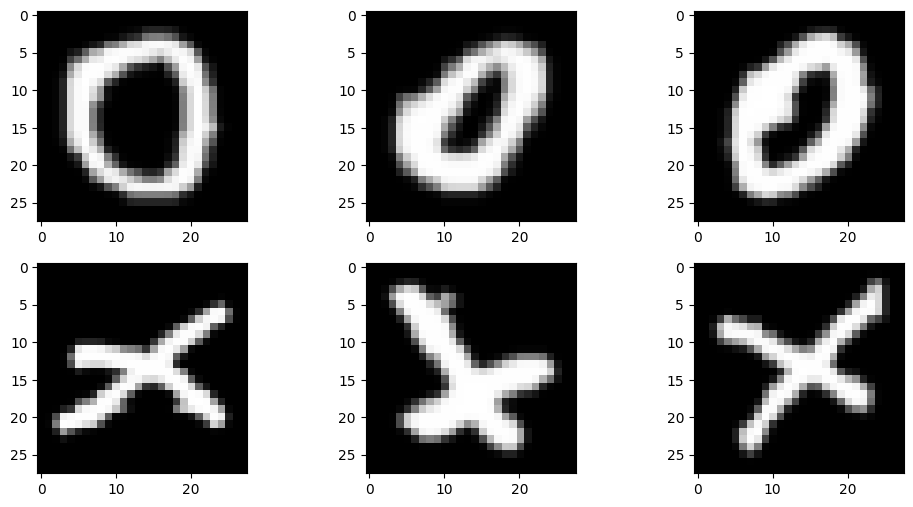

In [10]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[15][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
ax5.imshow(emnist_train[3][0].reshape(28, 28), cmap='gray')
ax6.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
plt.show()

# A visualization of the process

## Multiple filters

* For the following network, we set up 3 filters and run them on an image of the dataset from the X class.

In [11]:
class Net(nn.Module):

  def __init__(self, padding=0):
    """
    Initialize parameters of Net

    Args:
      padding: int or tuple, optional. Default: 0

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])

    #####################################################################
    # 1) Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    # 2) Set this tensor as the weight of self.conv1 --> use torch.nn.Parameter(...)
    #####################################################################

    # 1)
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    # 2)
    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    #####################################################################
    # 3) Apply the conv layer to the input
    #####################################################################

    x = self.conv1(x)
    return x


**Q1: Why did we  add a negative bias?**



The convolution operation performs a weighted sum (dot product) between the kernel and each patch of the input. If the patch **matches** the kernel well (i.e., their structure is similar), the dot product will be **high** (positive). If it **doesn't match**, the result will be **lower** or even negative.

Now, by adding a **negative bias**, we're **shifting the activation threshold**. This means:

Only **very strong matches** (i.e., high dot product values) will survive.

**Weaker or partial** matches will get pushed closer to 0 or negative — and may be cut off completely if followed by ReLU.

---
**Example**:

Imagine a kernel designed to detect an X shape:

If the input is truly an X, the dot product will be high, say **+10**.

If it's something else, maybe the dot product is **+2** or **-3**.

Now, if you add a **bias of -4**, the outputs become:

For the real X: `10 - 4 = 6`

For the non-X: `2 - 4 = -2` → possibly killed by ReLU

This acts like a **gate** — only strong signals pass through.

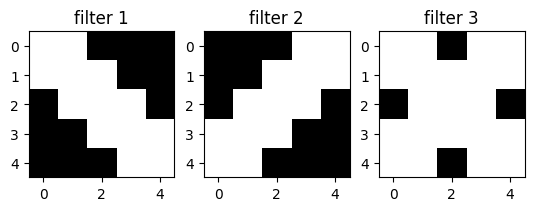

In [12]:
# Visualizing the filters

net = Net().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# Show the filters
ax11.set_title("filter 1")
ax11.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

**Q2: How do you think these filters would help to recognize X?**

**Filter 1: Diagonal from Top-Left to Bottom-Right**

- This filter lights up (white cells = high weights) along the main diagonal.

- An X has two crossing diagonals, so this filter will activate strongly when it sees that \ shape.

- So this filter is likely tuned to detect one arm of the X.

**Filter 2: Diagonal from Top-Right to Bottom-Left**
- This one is the mirror of filter 1 — detecting the other diagonal: the / shape.

- Combined with filter 1, it enables the network to detect both diagonals of an X.

**Filter 3: Corners and Center**
- This one's more subtle: it activates at the four corners and center of the patch.

- An X tends to have high-intensity pixels in the corners (because of the arms) and also a crossing point in the center.

- This filter helps confirm the full X pattern, ensuring that the diagonals really intersect at the center.

In [13]:
#####################################################################
# TODO:
# 1) Pass the image of 'X' and 'O' through the network to see the output
#####################################################################

net = Net().to(DEVICE)

# Prepare X image
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)  # shape: [1, 1, 28, 28]
output_x = net(x_img)  # shape: [1, 3, H, W]
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()  # shape: [3, H, W]

# Prepare O image
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)  # shape: [1, 1, 28, 28]
output_o = net(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()  # shape: [3, H, W]

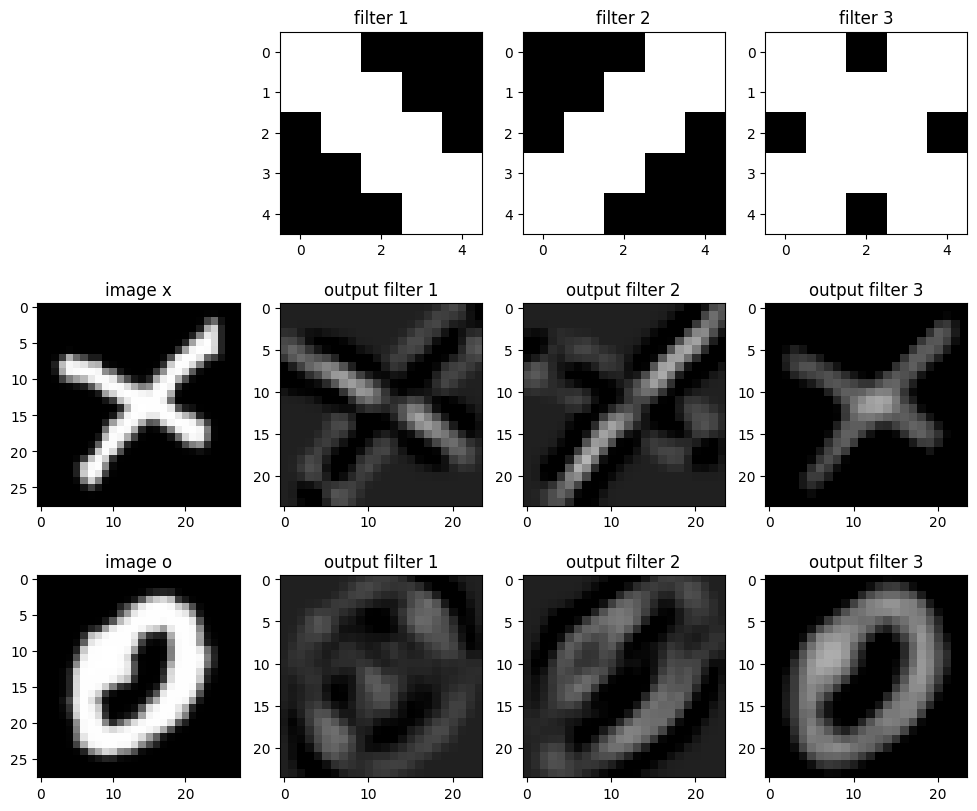

In [14]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## ReLU

* ReLU introduces non-linearity into our model, allowing to learn a more complex function that can better predict the class of an image.

* Let's incorporate ReLU into the previous model and visualize the output.


In [15]:
class Net2(nn.Module):

  def __init__(self, padding=0):
    """
    Initialize Net2 parameters

    Args:
      padding: int or tuple, optional. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])

    #####################################################################
    # 1) Stack all kernels in one tensor
    # 2) Set this tensor as the weight of self.conv1
    #####################################################################

    # 1)
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3])  # shape: (3, 1, 5, 5)

    # 2)
    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """
    #####################################################################
    # 1) Apply conv layer and ReLU to the input
    #####################################################################

    x = self.conv1(x)
    x = torch.relu(x)
    return x


In [16]:
# Apply the filters and relus to the images.

net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net2(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net2(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

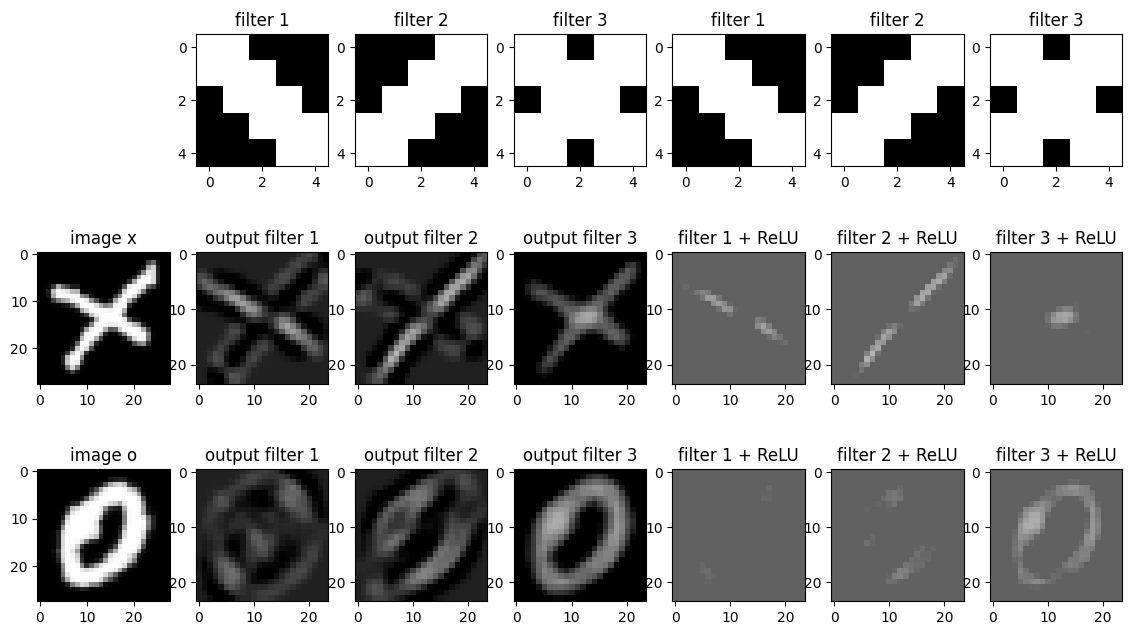

In [17]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 8))
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

**Q3: How do you think the ReLU activations help strengthen the features necessary to detect an image?**

* Suppressing Irrelevant Information (Noise Reduction)

  - Before ReLU, the output of the convolution contains both positive and negative values. Negative values often represent irrelevant features or background noise.

  - After ReLU, all negative values are set to zero, meaning only the most relevant edges and patterns are retained.

* Enhancing High-Contrast Features

    - In the output images, you can see that the ReLU activations highlight strong patterns in the `X` and `O` images while discarding weaker activations.

    - For `X`, the filters respond strongly to diagonal lines, which are preserved by ReLU.

    - For `O`, the filters capture circular edges, which remain visible in the ReLU output.


## MaxPooling

* Now Let's implement MaxPooling. We use a kernel of size 2 and stride of 2 for the MaxPooling layer.

In [20]:
class Net3(nn.Module):

  def __init__(self, padding=0, stride=2):
    """
    Initialize parameters of Net3

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, padding=padding)

    # First kernel
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])

    # 1) Stack all kernels in one tensor
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3])

    # 2) Set this tensor as the weight of self.conv1
    self.conv1.weight = nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

    # 3) Define a MaxPooling layer with a kernel of size 2 and stride of 2
    self.pool = nn.MaxPool2d(kernel_size=2, stride=stride)

  def forward(self, x):
    """
    Forward Pass of Net3

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU + Pooling output
    """
    # 4) Apply conv layer + ReLU + maxpool layer to the input
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    return x


In [21]:
# Apply the filters and relus to the images.

net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_pool = net3(x_img)
output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_pool = net3(o_img)
output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()

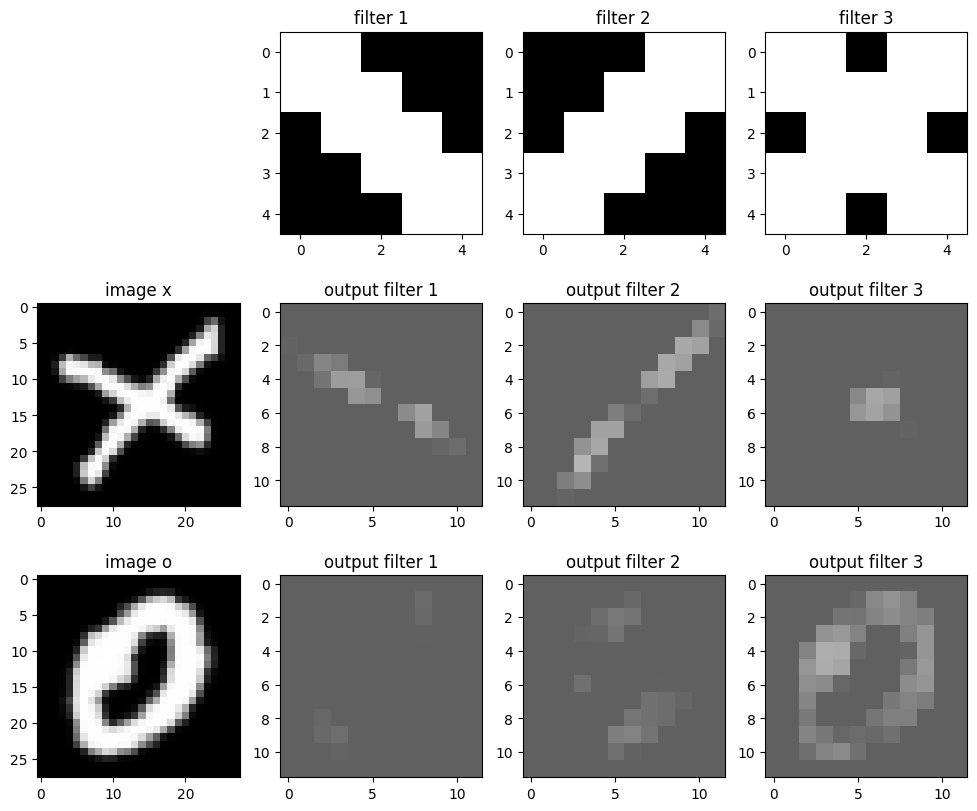

In [22]:
# Viewing what the output of the applied filters looks like

fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4, figsize=(12, 10))

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

* You can observe that after implementing Maxpool layer, the size of the output  being half of what you we after the ReLU section.

* Despite the reduction in the size of the output, the important or high-level features in the output still remains intact.

# Implement a CNN

For this section, you're going to create a CNN.

In [23]:
# Train/Test Functions
# You will code your training loop in HW_CNN_part2, you can run this cell for this HW for now

def train(model, device, train_loader, epochs):
  """
  Training function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    train_loader: torch.loader
      Training Set
    epochs: int
      Number of epochs

  Returns:
    Nothing
  """
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)

def test(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return acc

In [24]:
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 1404 has been set.


In [25]:
class EMNIST_Net(nn.Module):
  """
  Neural network instance with following structure:
  - Convolutional Layer 1: 1 --> 32, kernel_size=3
  - Convolutional Block 2: 32 --> 64, kernel_size=3 + maxpooling
  - Fully Connected Layer 1: 9216 --> 128
  - Fully Connected Layer 2: 128 --> 2
  """

  def __init__(self):
    """
    Initialize parameters of EMNISTNet
    """
    super(EMNIST_Net, self).__init__()

    # 1) Define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(64 * 12 * 12, 128)  # input size after conv2 + pool = 64 x 12 x 12
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    """
    Forward pass of EMNISTNet
    """
    x = self.conv1(x)         # [batch, 1, 28, 28] -> [batch, 32, 26, 26]
    x = F.relu(x)
    x = self.conv2(x)         # [batch, 32, 26, 26] -> [batch, 64, 24, 24]
    x = F.relu(x)
    x = self.pool(x)          # [batch, 64, 24, 24] -> [batch, 64, 12, 12]
    x = torch.flatten(x, 1)   # Flatten all but batch dimension
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


emnist_net = EMNIST_Net().to(DEVICE)
print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
train(emnist_net, DEVICE, train_loader, 1)

print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

Total Parameters in Network    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy is: 99.1875


## Softmax

* Now let's use softmax function which converts a real value to a value between 0 and 1, that can be interpreted as a probability.

Input1:


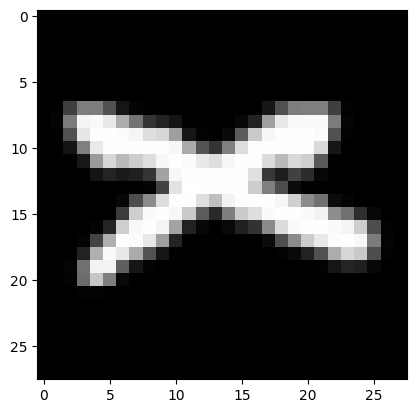


Result: tensor([[0.0015, 0.9985]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.0014562272699549794
Confidence of image being an 'X': 0.9985437393188477

--------------------------

Input2:


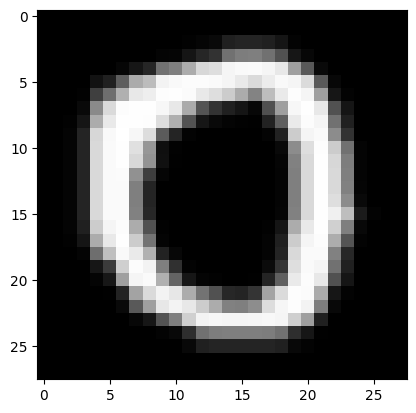


Result: tensor([[9.9988e-01, 1.2062e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Confidence of image being an 'O': 0.9998793601989746
Confidence of image being an 'X': 0.00012061846791766584


In [26]:
import torch.nn.functional as F

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input1:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

output = emnist_net(x_img)

# 1) Apply softmax
result = F.softmax(output, dim=1)

print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

print("\n--------------------------\n")

print("Input2:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

output = emnist_net(o_img)

# 1) Apply softmax
result = F.softmax(output, dim=1)

print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

* This is evident from the softmax output, which shows the probabilities of the image belonging to each of the classes.

# Compare with a Fully Connected Network

Train a simple fully connected neural network (MLP) on the same dataset. Compare its performance with your CNN in terms of accuracy, number of parameters, and training time. Explain why CNN performs better or worse.

## Define the MLP Model

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 classes: X and O

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # flatten from (B, 1, 28, 28) to (B, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train the MLP

In [ ]:
mlp_model = MLP().to(DEVICE)

print("Total Parameters in MLP {:10d}".format(sum(p.numel() for p in mlp_model.parameters())))
start_time = time.time()
train(mlp_model, DEVICE, train_loader, epochs=1)  # you can increase epochs
mlp_train_time = time.time() - start_time

mlp_test_acc = test(mlp_model, DEVICE, test_loader)
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Training Time: {mlp_train_time:.2f} seconds")

Total Parameters in MLP     108866


  0%|          | 0/300 [00:00<?, ?batch/s]

MLP Test Accuracy: 98.9375
MLP Training Time: 32.54 seconds


## Compare with CNN

In [ ]:
print("Total Parameters in CNN {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
start_time = time.time()
train(emnist_net, DEVICE, train_loader, epochs=1)
cnn_train_time = time.time() - start_time

cnn_test_acc = test(emnist_net, DEVICE, test_loader)
print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")
print(f"CNN Training Time: {cnn_train_time:.2f} seconds")

Total Parameters in CNN    1198850


  0%|          | 0/300 [00:00<?, ?batch/s]

CNN Test Accuracy: 99.3125
CNN Training Time: 33.77 seconds


## Analysis

`CNN Accuracy: 99.31%`

`MLP Accuracy: 98.94%`

* Why CNN is Better?
  
  - Spatial Hierarchy Learning:

    - CNNs use convolutional layers to detect local patterns (edges, curves, shapes) before combining them into higher-level features.

    - MLPs treat the input as a flat vector, losing spatial structure.

    - Since EMNIST is an image dataset, preserving spatial relationships helps in distinguishing "X" vs "O".

  - Translation Invariance:

    - CNNs are robust to small shifts in the input (e.g., if the digit is slightly off-center).

    - MLPs do not have this property—they rely on fixed pixel positions.

  - Parameter Efficiency:

    - CNNs use shared weights (kernels), reducing redundancy.

    - MLPs use dense connections, making them prone to overfitting if not properly regularized.

# Add Evaluation Metrics

In addition to overall accuracy, compute and report:
* Confusion matrix

* Model performance metrics


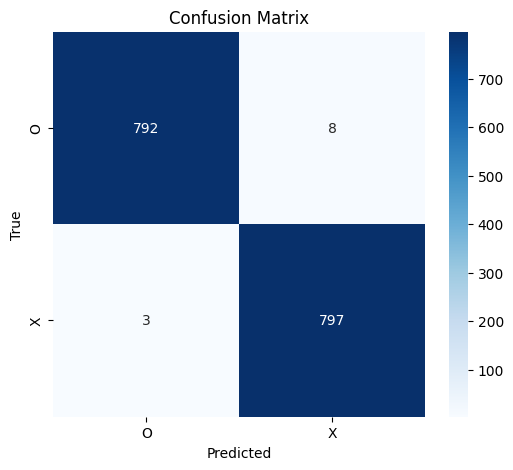

Classification Report:
               precision    recall  f1-score   support

           O       1.00      0.99      0.99       800
           X       0.99      1.00      0.99       800

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# First, get all true labels and predicted labels
def evaluate_model(model, device, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Run evaluation
y_pred, y_true = evaluate_model(emnist_net, DEVICE, test_loader)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['O', 'X'], yticklabels=['O', 'X'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (includes Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=['O', 'X'])
print("Classification Report:\n", report)


# Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.

## Train

In [ ]:
def train_with_loss(model, device, train_loader, optimizer, epochs):
    """
    Training function that returns loss values

    Args:
        model: nn.module
        device: string
        train_loader: torch.loader
        optimizer: torch.optim optimizer
        epochs: int

    Returns:
        losses: list of loss values per batch
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)

                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                losses.append(loss.item())
                tepoch.set_postfix(loss=loss.item())
                time.sleep(0.1)

    return losses

In [ ]:
# Initialize models
sgd_model = EMNIST_Net().to(DEVICE)
adam_model = EMNIST_Net().to(DEVICE)
rmsprop_model = EMNIST_Net().to(DEVICE)

# Define optimizers
sgd_optimizer = torch.optim.SGD(sgd_model.parameters(), lr=0.01)
adam_optimizer = torch.optim.Adam(adam_model.parameters(), lr=0.001)
rmsprop_optimizer = torch.optim.RMSprop(rmsprop_model.parameters(), lr=0.001)

# Train models and collect losses
epochs = 1
sgd_losses = train_with_loss(sgd_model, DEVICE, train_loader, sgd_optimizer, epochs)
adam_losses = train_with_loss(adam_model, DEVICE, train_loader, adam_optimizer, epochs)
rmsprop_losses = train_with_loss(rmsprop_model, DEVICE, train_loader, rmsprop_optimizer, epochs)

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

## Plot

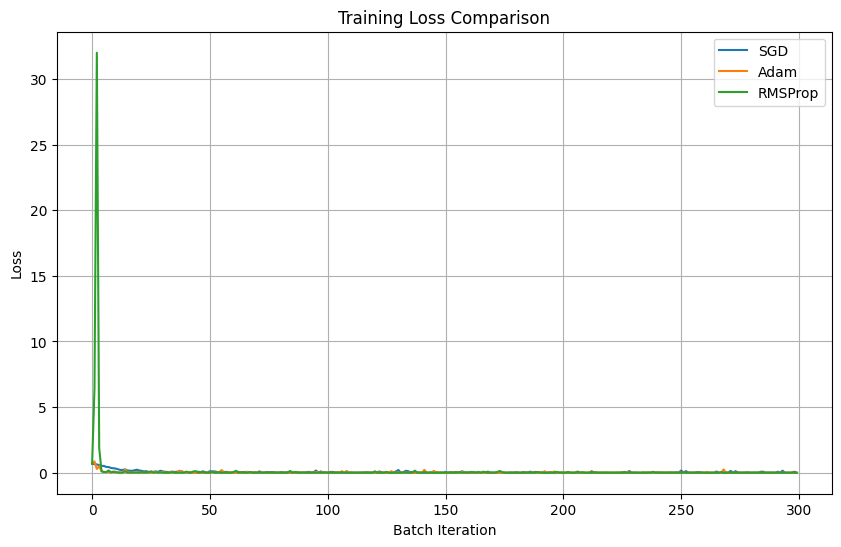

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, label='SGD')
plt.plot(adam_losses, label='Adam')
plt.plot(rmsprop_losses, label='RMSProp')
plt.xlabel('Batch Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [ ]:
print("SGD Test Accuracy:", test(sgd_model, DEVICE, test_loader))
print("Adam Test Accuracy:", test(adam_model, DEVICE, test_loader))
print("RMSProp Test Accuracy:", test(rmsprop_model, DEVICE, test_loader))

SGD Test Accuracy: 99.0
Adam Test Accuracy: 99.5625
RMSProp Test Accuracy: 99.5625


# Compare Activation Functions

Replace ReLU with Tanh or LeakyReLU. How does that affect performance?

## tanh

In [ ]:
class EMNIST_Net_Tanh(nn.Module):
    def __init__(self):
        super(EMNIST_Net_Tanh, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)  # Changed to Tanh
        x = self.conv2(x)
        x = torch.tanh(x)  # Changed to Tanh
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.tanh(x)  # Changed to Tanh
        x = self.fc2(x)
        return x

## LeakyRelu

In [ ]:
class EMNIST_Net_LeakyReLU(nn.Module):
    def __init__(self):
        super(EMNIST_Net_LeakyReLU, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 2)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # Default slope

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)  # Changed to LeakyReLU
        x = self.conv2(x)
        x = self.leaky_relu(x)  # Changed to LeakyReLU
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.leaky_relu(x)  # Changed to LeakyReLU
        x = self.fc2(x)
        return x

## Train&Test

In [ ]:
# Initialize models
set_seed(SEED)
tanh_model = EMNIST_Net_Tanh().to(DEVICE)
leaky_model = EMNIST_Net_LeakyReLU().to(DEVICE)

# Train both models
print("Training Tanh model:")
train(tanh_model, DEVICE, train_loader, epochs=1)
print("\nTraining LeakyReLU model:")
train(leaky_model, DEVICE, train_loader, epochs=1)

# Test both models
print("\nTest accuracy:")
print(f'Tanh version: {test(tanh_model, DEVICE, test_loader):.2f}%')
print(f'LeakyReLU version: {test(leaky_model, DEVICE, test_loader):.2f}%')

Random seed 1404 has been set.
Training Tanh model:


  0%|          | 0/300 [00:00<?, ?batch/s]


Training LeakyReLU model:


  0%|          | 0/300 [00:00<?, ?batch/s]


Test accuracy:
Tanh version: 99.19%
LeakyReLU version: 99.25%


## Analysis

`Raw Network (ReLU): 99.31%`

`Tanh: 99.19%`

`LeakyReLU: 99.25%`

- Performance Comparison:
  - ReLU still performs slightly better than both alternatives in this case.
- Why Such Small Differences?
  - Our network is relatively shallow (only 2 conv layers)

  - The EMNIST digit classification step is not extremely complex

  - With such high baseline accuracy (>99%), there's limited room for improvement

# Train a Deeper CNN

Extend the network with your desired additional layers. Does it help or hurt performance?

## Defining the new module

In [ ]:
class Extended_EMNIST_Net(nn.Module):
    """
    Extended neural network with following structure:
    - Convolutional Layer 1: 1 → 32, kernel_size=3 + BatchNorm
    - Convolutional Block 2: 32 → 64, kernel_size=3 + BatchNorm + maxpooling
    - Convolutional Block 3: 64 → 128, kernel_size=3 + BatchNorm + maxpooling
    - Fully Connected Layer 1: 128 * 5 * 5 → 256
    - Fully Connected Layer 2: 256 → 128
    - Fully Connected Layer 3: 128 → 2
    """

    def __init__(self):
        super(Extended_EMNIST_Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 5 * 5, 256)  # Size after conv3 + pool
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)       # [batch, 1, 28, 28] → [batch, 32, 26, 26]
        x = self.bn1(x)
        x = F.relu(x)

        # Conv block 2
        x = self.conv2(x)       # [batch, 32, 26, 26] → [batch, 64, 24, 24]
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)        # [batch, 64, 24, 24] → [batch, 64, 12, 12]

        # Conv block 3
        x = self.conv3(x)       # [batch, 64, 12, 12] → [batch, 128, 10, 10]
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)        # [batch, 128, 10, 10] → [batch, 128, 5, 5]

        # Fully connected
        x = torch.flatten(x, 1) # [batch, 128, 5, 5] → [batch, 128*5*5]
        x = self.fc1(x)         # → [batch, 256]
        x = F.relu(x)
        x = self.fc2(x)         # → [batch, 128]
        x = F.relu(x)
        x = self.fc3(x)         # → [batch, 2]

        return x

## Train&Test

Total Parameters: 945730


  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

  0%|          | 0/300 [00:00<?, ?batch/s]

Test accuracy: 99.5625%


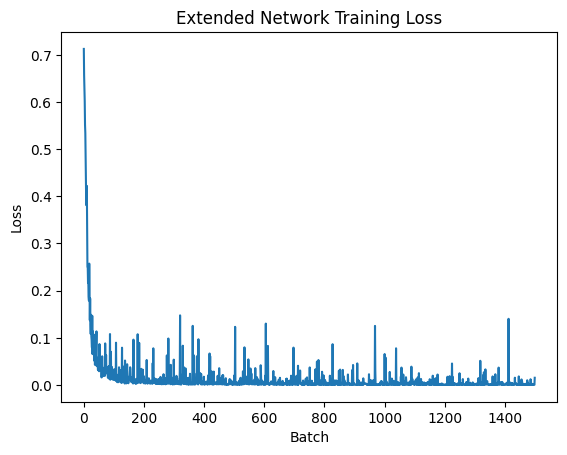

In [ ]:
# Initialize and train
extended_net = Extended_EMNIST_Net().to(DEVICE)
print("Total Parameters:", sum(p.numel() for p in extended_net.parameters()))

# Use SGD as originally specified
optimizer = torch.optim.SGD(extended_net.parameters(), lr=0.01)
losses = train_with_loss(extended_net, DEVICE, train_loader, optimizer, epochs=5)

# Test
print(f'Test accuracy: {test(extended_net, DEVICE, test_loader)}%')

# Plot losses
plt.plot(losses)
plt.title("Extended Network Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

## Analysis

**Performance Metrics**

| **Metric**          | **Original Network** | **Extended Network** | **Improvement** |
|---------------------|----------------------|----------------------|-----------------|
| **Test Accuracy**   | 99.31%               | **99.56%**           | **+0.25%**      |
| **Final Loss**      | ~0.1 (estimated)     | **~0.05** (from plot)| **~50% lower**  |

---

**Why the Improvement?**
- **For High Initial Accuracy (99.3%+):**  
  - Small gains are significant because the model is already near the "ceiling" for this task.  
  - The **0.25% improvement** could reflect better handling of edge cases (e.g., distorted digits).  
